In [1]:
%load_ext autoreload
%autoreload 2

## Super resolution

In [2]:
import fastai
from fastai.vision import *
from fastai.callbacks import *

from torchvision.models import vgg16_bn
torch.cuda.is_available()

True

In [3]:
path = Path('./data/crappified/dataset_1/')
path_hr = path/'orig_spectr'
path_lr = path/'crap_spectr'

In [4]:
meta_spectr= pd.read_csv('./data/crappified/dataset_1/meta/meta_spectr.csv')
meta_spectr.subset = meta_spectr.subset == 'valid'

In [5]:
il = ImageList.from_folder(path_hr)

In [6]:
il

ImageList (657823 items)
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: data/crappified/dataset_1/orig_spectr

In [7]:
bs,size=32,128
arch = models.resnet34

src = ImageImageList.from_df(meta_spectr, path_lr).split_from_df('subset')
# src = ImageImageList.from_folder(path_lr).split_by_rand_pct()

In [8]:
src

ItemLists;

Train: ImageImageList (527073 items)
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: data/crappified/dataset_1/crap_spectr;

Valid: ImageImageList (130750 items)
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: data/crappified/dataset_1/crap_spectr;

Test: None

In [9]:
path_hr

PosixPath('data/crappified/dataset_1/orig_spectr')

In [10]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/os.path.basename(x))
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data

In [6]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [11]:
data = get_data(bs,size)

In [12]:
data

ImageDataBunch;

Train: LabelList (527073 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: data/crappified/dataset_1/crap_spectr;

Valid: LabelList (130750 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: data/crappified/dataset_1/crap_spectr;

Test: None

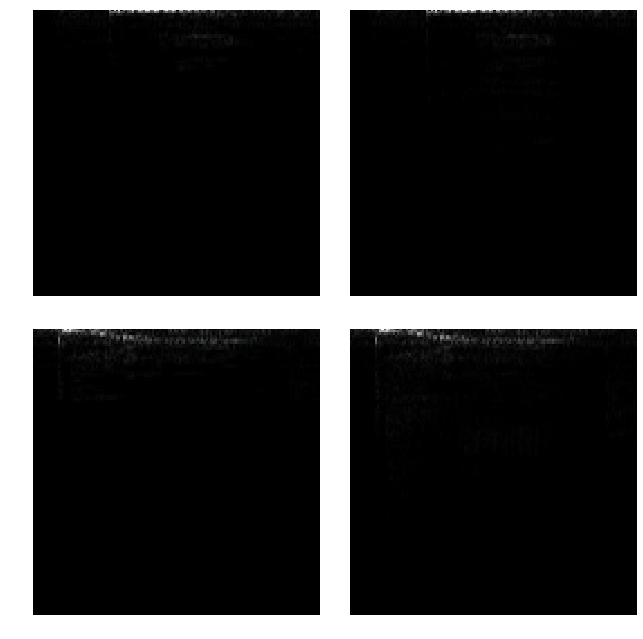

In [13]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

## Feature loss

In [14]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [15]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [16]:
gram_matrix(t)

tensor([[[0.0004, 0.0004, 0.0004],
         [0.0004, 0.0004, 0.0004],
         [0.0004, 0.0004, 0.0004]],

        [[0.0004, 0.0004, 0.0004],
         [0.0004, 0.0004, 0.0004],
         [0.0004, 0.0004, 0.0004]]])

In [17]:
base_loss = F.l1_loss

In [18]:
vgg_m = vgg16_bn(True).features
new_weights = torch.load('./data/crappified/dataset_1/model_clas/model_1_weights.pth')
vgg_m.load_state_dict(torch.load('./data/crappified/dataset_1/model_clas/model_1_weights.pth'), strict= False)
vgg_m.cuda().eval()
requires_grad(vgg_m, False)

In [19]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [20]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [21]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train

In [22]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight, path = './data/crappified/dataset_1/')
gc.collect();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


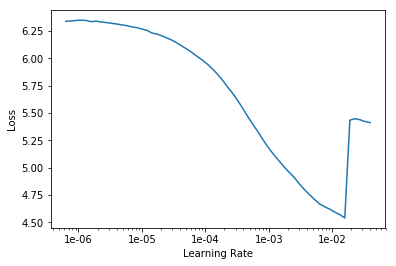

In [23]:
learn.lr_find()
learn.recorder.plot()

In [25]:
lr = 1e-3

In [28]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(4, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

In [25]:
learn.load('1a')

/home/ludovic/miniconda3/envs/crystal_clear/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=ImageDataBunch;

Train: LabelList (527073 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: data/crappified/dataset_1/crap_spectr;

Valid: LabelList (130750 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: data/crappified/dataset_1/crap_spectr;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, cei

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,0.699681,0.704337,0.017841,0.082073,0.100819,0.015963,0.163539,0.308360,0.015741,2:36:50


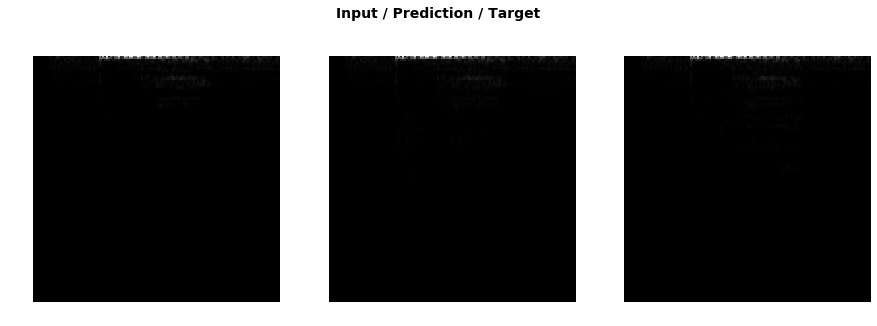

In [26]:
do_fit('1a_bis', slice(lr*10))

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,0.687192,0.702228,0.017785,0.081767,0.100510,0.015926,0.162972,0.307565,0.015703,2:33:53


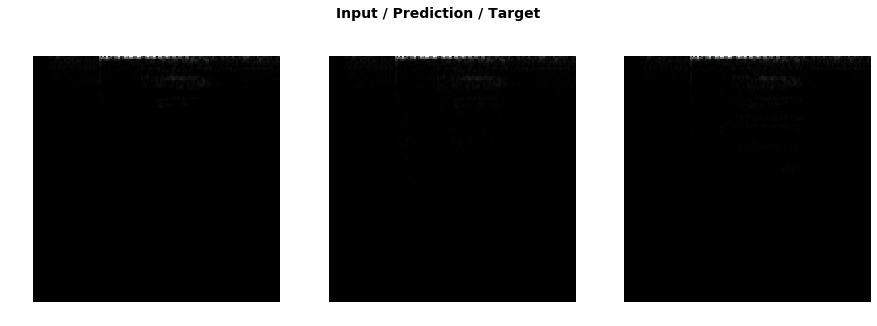

In [28]:
do_fit('1a_3', slice(lr*10))

In [28]:
learn.load('1a3')

/home/ludovic/miniconda3/envs/crystal_clear/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=ImageDataBunch;

Train: LabelList (527073 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: data/crappified/dataset_1/crap_spectr;

Valid: LabelList (130750 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: data/crappified/dataset_1/crap_spectr;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, cei

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,0.669163,0.704130,0.018351,0.081211,0.100223,0.015894,0.164809,0.307949,0.015693,2:32:20
1,0.698732,0.712389,0.019524,0.083588,0.101899,0.016069,0.164663,0.310772,0.015874,2:29:34
2,0.705132,0.743593,0.021348,0.084253,0.104747,0.016105,0.172514,0.328791,0.015834,2:29:53
3,0.669141,0.697294,0.017737,0.081584,0.099922,0.015819,0.161495,0.305158,0.015580,2:32:00


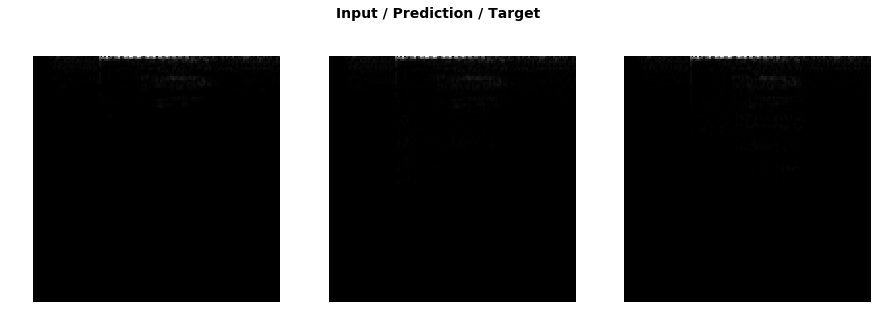

In [30]:
do_fit('1a4', slice(lr*10))

In [31]:
learn.export("./models_export/1a4.pkl")

/home/ludovic/miniconda3/envs/crystal_clear/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [23]:
learn.load('1a4')

/home/ludovic/miniconda3/envs/crystal_clear/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=ImageDataBunch;

Train: LabelList (527073 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: data/crappified/dataset_1/crap_spectr;

Valid: LabelList (130750 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: data/crappified/dataset_1/crap_spectr;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, cei

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


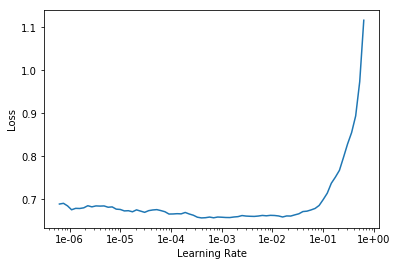

In [24]:
learn.lr_find()
learn.recorder.plot()

In [25]:
lr = 1e-3

In [26]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,0.664041,0.701817,0.017866,0.082112,0.100496,0.015838,0.162684,0.307238,0.015583,2:38:12
1,0.674025,0.699260,0.017865,0.081873,0.100275,0.015843,0.161806,0.305985,0.015612,2:38:15
2,0.667149,0.697672,0.017854,0.081784,0.100208,0.015814,0.161250,0.305188,0.015575,2:38:18
3,0.656098,0.695402,0.017672,0.081583,0.099865,0.015786,0.160796,0.304154,0.015545,2:39:41


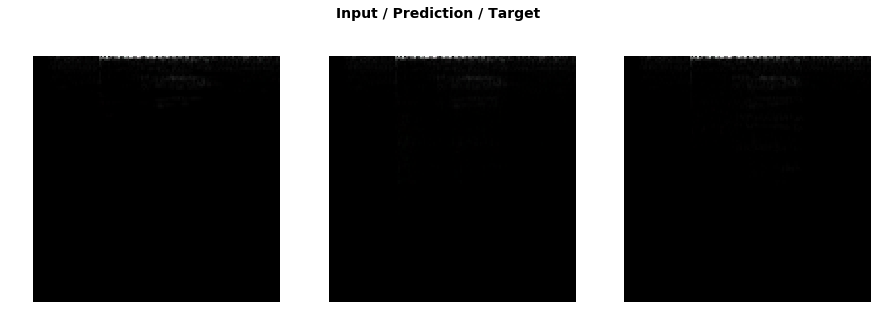

In [29]:
do_fit('1b', slice(1e-5,lr))

In [30]:
learn.export("./models_export/1b.pkl")

/home/ludovic/miniconda3/envs/crystal_clear/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
data = get_data(12,size*2)

In [ ]:
learn.data = data
learn.freeze()
gc.collect()

In [ ]:
learn.load('1b');

In [ ]:
do_fit('2a')

In [ ]:
learn.unfreeze()

In [ ]:
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)

# Music_reconstruction

In [24]:
learn.load('1a')

/home/ludovic/miniconda3/envs/crystal_clear/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=ImageDataBunch;

Train: LabelList (527073 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: data/crappified/dataset_1/crap_spectr;

Valid: LabelList (130750 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: data/crappified/dataset_1/crap_spectr;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, cei

In [26]:
learn.export('./models_export/1a.pkl')

/home/ludovic/miniconda3/envs/crystal_clear/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [4]:
learn = load_learner('./data/crappified/dataset_1/models_export/', '1a.pkl')

AttributeError: Can't get attribute 'FeatureLoss' on <module '__main__'>

In [29]:
from pydub import AudioSegment
import scipy
from scipy.signal import stft
from crystal_clear.prepare import *

In [30]:
Im0 = open_image(path_lr / '2_0.png')
res = learn.predict(Im0)
res[2].max()

tensor(2.2831)

In [31]:
def reconstruct(path_mp3, path_images, track_id, learner=None):
    nperseg = 254
    song = AudioSegment.from_mp3(path_mp3)
    n_channels = song.channels
    samples = np.array(song.get_array_of_samples()).reshape(n_channels, -1, order='F')
    # return samples
    sample_rate = song.frame_rate
    f, t, Zxx = scipy.signal.stft(samples, sample_rate, nperseg=nperseg)
    data, r = make_3D_into_square(make_into_3D(np.abs(Zxx)))
    n_window = len(data)
    for i, array in enumerate(data):
        m = array.max()
        if learner is None:
            data_from_img = np.array(Image.open(path_images / f'{track_id}_{i}.png'))
            data_from_img = np.moveaxis(data_from_img, -1, 0)
            data_from_img = data_from_img / 255 * m
        else:
            data_from_img = learner.predict(open_image(path_images / f'{track_id}_{i}.png'))[0].data.numpy()
            data_from_img = data_from_img * m
        data[i] = data_from_img.astype(np.float32)
    if r !=0:
        data[-1] = data[-1][:, :, :r]
    data = np.concatenate(data, axis=2)
    data = data[:n_channels]
    angle = (Zxx / np.abs(Zxx))
    angle[np.isnan(angle)] = 1
    new_Zxx = angle * data
    _, reconstructed = scipy.signal.istft(new_Zxx, sample_rate)
    reconstructed = np.rint(reconstructed).astype(np.int16)
    song._data = bytearray(reconstructed.reshape(1, -1, order='F'))
    return song

In [32]:
meta = pd.read_csv('./data/crappified/dataset_1/meta/meta_spectr.csv')
meta[meta.subset == 'valid'].head()

,spectr_id,genre,subset
82,5_0.png,Hip-Hop,valid
83,5_1.png,Hip-Hop,valid
84,5_2.png,Hip-Hop,valid
85,5_3.png,Hip-Hop,valid
86,5_4.png,Hip-Hop,valid


In [33]:
track_id = 5
path_orig = path_mp3(2)
path_crap = Path('./data/crappified/dataset_1/mp3/2.mp3')
path_image = Path('./data/crappified/dataset_1/crap_spectr/')
orig = AudioSegment.from_mp3(path_orig)
crap = AudioSegment.from_mp3(path_crap)
reconstructed = reconstruct(path_crap, path_image, 2, learn)
print('original')
display(orig)
print('crappified')
display(crap)
print('reconstructed')
display(reconstructed)
orig.export('samples/sample_1_orig.mp3', format = 'mp3')
crap.export('samples/sample_1_crap.mp3', format = 'mp3')
reconstructed.export('samples/sample_1_reconstruct.mp3', format = 'mp3')

original


crappified


reconstructed


<_io.BufferedRandom name='samples/sample_1_reconstruct.mp3'>

## Test

In [ ]:
learn = None
gc.collect();

In [ ]:
256/320*1024

819.2

In [ ]:
256/320*1600

1280.0

In [ ]:
learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)

In [ ]:
data_mr = (ImageImageList.from_folder(path_mr).random_split_by_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(get_transforms(), size=(1280,1600), tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_mr.c = 3

In [ ]:
learn.load('2b');

In [ ]:
learn.data = data_mr

In [ ]:
fn = data_mr.valid_ds.x.items[0]; fn

PosixPath('/data1/jhoward/git/course-v3/nbs/dl1/data/oxford-iiit-pet/small-256/Siamese_178.jpg')

In [ ]:
img = open_image(fn); img.shape

torch.Size([3, 256, 320])

In [ ]:
p,img_hr,b = learn.predict(img)

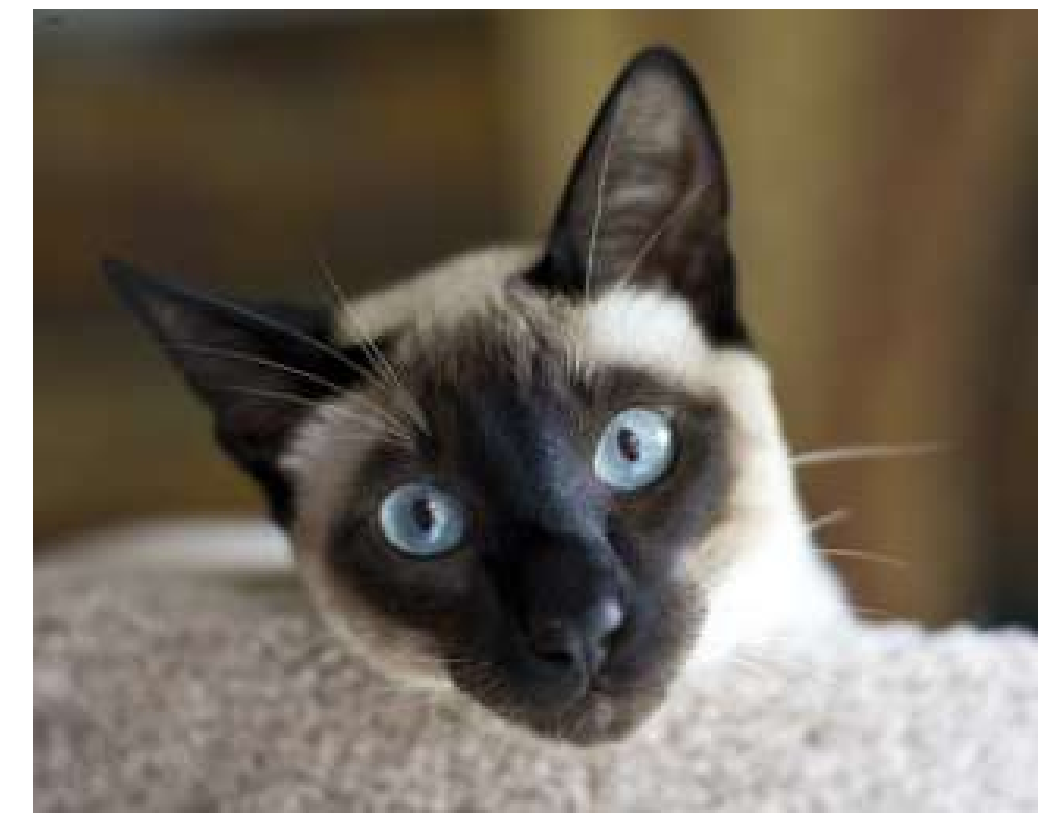

In [ ]:
show_image(img, figsize=(18,15), interpolation='nearest');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


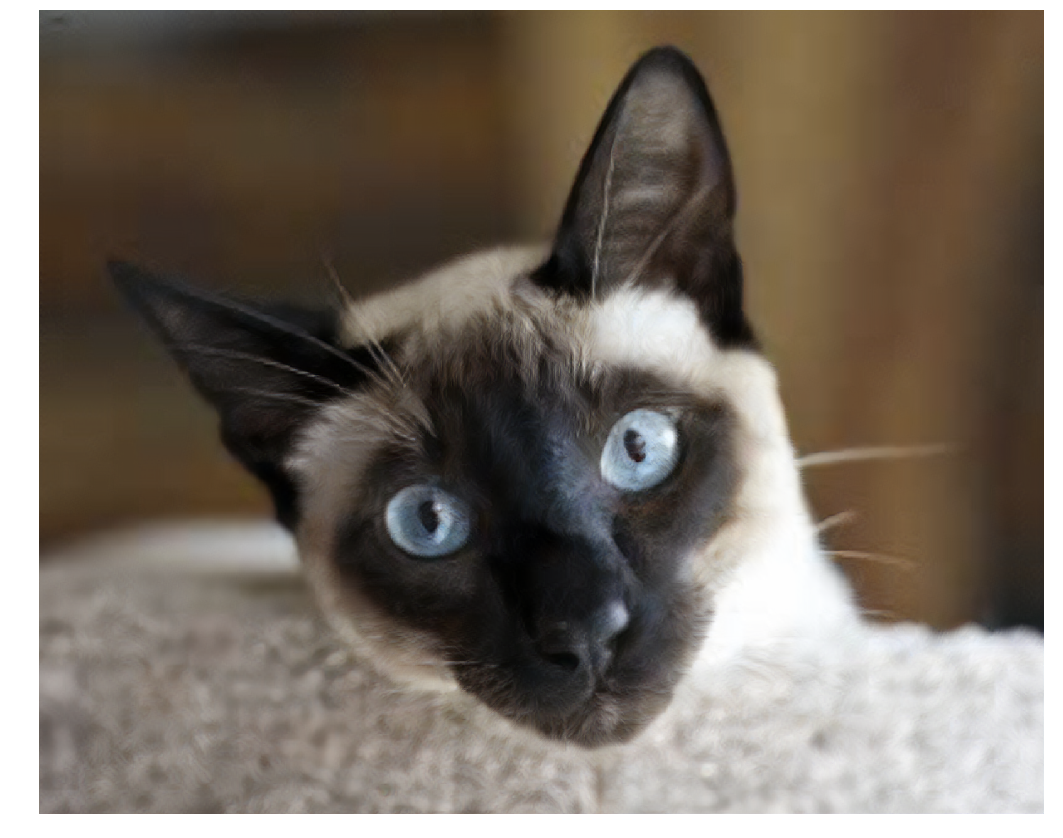

In [ ]:
Image(img_hr).show(figsize=(18,15))